In [7]:
## Import

In [8]:
import wntr
import networkx as nx
import scipy.sparse as sp
import numpy as np 
import random
import tqdm
import os 
import matplotlib.pyplot as plt
import itertools
from collections import Counter 
import networkx as nx
import copy
import pandas as pd
import tensorflow_gnn as tfgnn
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [9]:
## Import network

In [10]:
network = 'stkl_no_control'
inp_file = network + '.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

In [11]:
wn = wntr.network.WaterNetworkModel(inp_file)  # reset value
wn.options.hydraulic.demand_model = 'DD' #dynamic demand model
results = wntr.sim.EpanetSimulator(wn).run_sim(version=2.0)
head = results.node['head']
demand = results.node['demand']
demand = np.maximum(demand, 0)
num_nodes = wn.num_nodes

In [12]:
timesteps = demand.index.tolist()

In [7]:
num_nodes

1106

In [94]:
monitor_point = pd.read_excel('Monitor_points.xlsx')
monitor_b = monitor_point['Branch point'].sample(n= 110, random_state=42)
monitor_point = pd.read_excel('Area_point.xlsx')
monitor_a = monitor_point['Area point'].sample(n= 110, random_state=42)

In [95]:
monitor = monitor_a.append(monitor_b, ignore_index=True)
print(monitor)

0       841
1      2629
2      2109
3      2382
4      2532
       ... 
215     525
216     516
217    1044
218    1363
219     523
Length: 220, dtype: int64


C:\Users\TianZhang\AppData\Local\Temp\ipykernel_22988\1897181280.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  monitor = monitor_a.append(monitor_b, ignore_index=True)


In [27]:
# Calculate the total number of timesteps
num_timesteps = len(timesteps)

# Initialize the 3-dimensional array 'A' to store link information
num_links = wn.num_links
A = np.zeros((num_timesteps, num_links, 4))

# Outer loop to go through each timestep in the sequence
for timestep_idx in range(num_timesteps):
    # Inner loop to go through each link in the water network
    for i, (_, link) in enumerate(wn.links()):
        # Extract the numeric part of the node names using string manipulation
        start_node_name = link.start_node.name
        end_node_name = link.end_node.name
        A[timestep_idx, i, 0] =float( start_node_name[-4:])
        A[timestep_idx, i, 1] = float(end_node_name[-4:])
        A[timestep_idx, i, 2] = float(link.name[-4:])
        # Access loss coefficient from the DataFrame 'loss_co'
        if link.link_type=='Pipe':
            A[timestep_idx, i, 3] = 1/(10.667*link.length/link.roughness**1.852/link.diameter**4.871)
            i+=1
        elif link.link_type=='Pump':
            A[timestep_idx, i, 3] = 1        
        elif link.link_type=='Valve':
            A[timestep_idx, i, 3] = 2        
        else:
            print('Other types of links exist.')

# After the loops, 'A' will contain the required link information for each timestep

In [42]:
num_nodes = wn.num_nodes
B = np.zeros((num_timesteps, num_nodes, 6))

Node_indicator = np.tile(np.arange(1, num_nodes+1), num_timesteps)
Nd_single = np.array([0 if node.node_type=='Junction' and node.name not in monitor
                   else 1 for _,node in wn.nodes()])
Nd = np.tile(Nd_single,num_timesteps)
Nd = Nd.squeeze()
#### Measurement indicator (if the node has head, measurement indicator = 1) (fully-supervised, all 1)
Nh_single = np.zeros(num_nodes)
Nh = np.tile(Nh_single,num_timesteps)
Nh = Nh.squeeze()

for timestep_idx in range(num_timesteps):

    for i, (_, node) in enumerate(wn.nodes()):
        B[timestep_idx, i, 0] = timesteps[timestep_idx]
        B[timestep_idx, i, 1] = float(node.name[-4:])
        B[timestep_idx, i, 2] = Nd[i]
        B[timestep_idx, i, 3] = demand.iloc[timestep_idx][i]*3.6
        B[timestep_idx, i, 4] = Nh[i]
        B[timestep_idx, i, 5] = head.iloc[timestep_idx][i]

In [43]:
U = np.zeros((num_timesteps, num_nodes, 2))
timestep_idx = 0
for timestep_idx in range(num_timesteps):
    for i, (_, node) in enumerate(wn.nodes()):
        U[timestep_idx, i, 0] = float(node.name[-4:])
        U[timestep_idx, i, 1] = head.iloc[timestep_idx][i]

In [44]:
array_3d_shape = B.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
B_2d = B.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
node_df = pd.DataFrame(B_2d)

array_3d_shape = A.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
A_2d = A.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
edge_df = pd.DataFrame(A_2d)

array_3d_shape = U.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
U_2d = U.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
head_df = pd.DataFrame(U_2d)

In [45]:
head_df.rename(columns={0: 'Node_indicator',1: 'head'},inplace=True)
edge_df.rename(columns={0: 'source', 1: 'target', 2:'link_name',3: 'loss_co'},inplace=True)
node_df.rename(columns={0:'Time_indicator', 1: 'Node_indicator', 2:'Junction_in',3: 'demand', 4: 'Measurement_in',5:'measurement'},inplace=True)

In [46]:
node_df_copy = node_df.copy()

# Get the indices where Node_indicator is not in the monitor array
monitor_indices = node_df_copy.loc[~node_df_copy['Node_indicator'].isin(monitor)].index
nmonitor_indices = node_df_copy.loc[node_df_copy['Node_indicator'].isin(monitor)].index
# Set measurement to 0 for rows where Node_indicator is not in the monitor array
node_df_copy.loc[monitor_indices, 'measurement'] = 0
node_df_copy.loc[nmonitor_indices, 'Measurement_in'] = 1
# Display the modified DataFrame
print(node_df_copy)

        Time_indicator  Node_indicator  Junction_in    demand  Measurement_in  \
0                  0.0             1.0          0.0  0.000041             1.0   
1                  0.0             3.0          0.0  0.000023             0.0   
2                  0.0             4.0          0.0  0.000014             0.0   
3                  0.0             5.0          0.0  0.000069             0.0   
4                  0.0             6.0          0.0  0.000100             0.0   
...                ...             ...          ...       ...             ...   
107277         86400.0          2676.0          0.0  0.000082             0.0   
107278         86400.0          2677.0          0.0  0.000014             0.0   
107279         86400.0          2744.0          0.0  0.000085             0.0   
107280         86400.0          2745.0          0.0  0.000014             0.0   
107281         86400.0             1.0          1.0  0.000000             1.0   

        measurement  
0    

In [96]:
edge_df.to_csv('edge_df.csv')
node_df_copy.to_csv('node_df_copy.csv')
head_df.to_csv('head_df.csv')

In [57]:
# Edge
## Create a StandardScaler object
scaler = StandardScaler()

## Select the column to scale
column_to_scale = 'loss_co'

## Fit and transform the selected column
edge_df[column_to_scale] = scaler.fit_transform(edge_df[[column_to_scale]])
#
# Node
## Create a StandardScaler object
scaler = StandardScaler()

## Select the column to scale
columns_to_scale = ['demand', 'measurement']

# Fit and transform the selected columns
node_df_copy[columns_to_scale] = scaler.fit_transform(node_df_copy[columns_to_scale])
#

# Graph
## Create a StandardScaler object
scaler = StandardScaler()

## Select the column to scale
columns_to_scale = ['head']

# Fit and transform the selected columns
head_df[columns_to_scale] = scaler.fit_transform(head_df[columns_to_scale])


In [59]:
test_edge_df = edge_df[num_links * (num_timesteps - 34):]
test_node_df = node_df_copy[num_nodes * (num_timesteps - 34):]
test_head_df = head_df[num_nodes * (num_timesteps - 34):]

train_edge_df = edge_df[: num_links * (num_timesteps - 60)]
train_node_df = node_df_copy[: num_nodes * (num_timesteps - 60)]
train_head_df = head_df[: num_nodes * (num_timesteps - 60)]

vali_edge_df = edge_df[ num_links * (num_timesteps - 60): num_links * (num_timesteps - 34)]
vali_node_df = node_df_copy[ num_nodes * (num_timesteps - 60): num_nodes * (num_timesteps - 34)]
vali_head_df = head_df[ num_nodes * (num_timesteps - 60): num_nodes * (num_timesteps - 34)]

In [60]:
def create_graph_tensor(node_df, edge_df,head_df):
    graph_tensor = tfgnn.GraphTensor.from_pieces(

        node_sets={
            "node": tfgnn.NodeSet.from_fields(
                sizes=[len(node_df)],
                features={
                    #'Node_indicator':np.array(node_df['Node_indicator'], dtype='int32').reshape(len(node_df),1),
                    'Junction_in':np.array(node_df['Junction_in'], dtype='int32').reshape(len(node_df),1),
                    'demand': np.array(node_df['demand'], dtype='float32').reshape(len(node_df),1),
                    'Measurement_in': np.array(node_df['Measurement_in'], dtype='int32').reshape(len(node_df),1),
                    'measurement': np.array(node_df['measurement'], dtype='float32').reshape(len(node_df),1),
                    'head': np.array(head_df['head'], dtype='float32').reshape(len(head_df),1),
                }
            )
        },
        edge_sets={
            "link": tfgnn.EdgeSet.from_fields(
                sizes=[len(edge_df)],
                features={
                    'loss_co': np.array(edge_df['loss_co'], dtype='float32').reshape(len(edge_df),1),
                   # 'flowrate': np.array(edge_df['flowrate'], dtype='float32').reshape(len(edge_df),1),
                },
                adjacency=tfgnn.Adjacency.from_indices(
                                          source=("node", np.array(edge_df['source'], dtype='int32')),
                                          target=("node", np.array(edge_df['target'], dtype='int32')),
                                      ))
        }
    )

    return graph_tensor


In [61]:
full_tensor = create_graph_tensor(node_df_copy, edge_df,head_df)
train_tensor = create_graph_tensor(train_node_df, train_edge_df, train_head_df)
test_tensor = create_graph_tensor(test_node_df, test_edge_df, test_head_df)
vali_tensor = create_graph_tensor(vali_node_df, vali_edge_df, vali_head_df)

In [62]:
def node_batch_merge(graph):
    graph = graph.merge_batch_to_components()
    node_features = graph.node_sets['node'].get_features_dict()
    edge_features = graph.edge_sets['link'].get_features_dict()
    
    label = node_features.pop('head')
    print(label)
    new_graph = graph.replace_features(node_sets={'node': node_features}, edge_sets={'link': edge_features})
    
    return new_graph, label


     
def create_dataset(graph, function):
    dataset = tf.data.Dataset.from_tensors(graph)
    dataset = dataset.batch(32)
    return dataset.map(function)

In [63]:
full_node_dataset = create_dataset(full_tensor, node_batch_merge)
train_node_dataset = create_dataset(train_tensor, node_batch_merge)
test_node_dataset = create_dataset(test_tensor, node_batch_merge)
vali_node_dataset = create_dataset(vali_tensor, node_batch_merge)

Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)


In [64]:
graph_spec = train_node_dataset.element_spec[0]
input_graph = tf.keras.layers.Input(type_spec=graph_spec)

In [65]:
def set_initial_node_state(node_set, node_set_name):
    features = [
        #tf.keras.layers.Dense(32, activation="relu")(node_set['Node_indicator']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['Junction_in']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['demand']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['Measurement_in']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['measurement']),
    ]
    return tf.keras.layers.Concatenate()(features)


def set_initial_edge_state(edge_set, edge_set_name):
    features = [
        tf.keras.layers.Dense(32, activation="leaky_relu")(edge_set['loss_co']),
        #tf.keras.layers.Dense(32, activation="leaky_relu")(edge_set['flowrate']),
    ]
    return tf.keras.layers.Concatenate()(features)




In [66]:
def dense_layer(units=128, l2_reg=0.01, dropout=0.5, activation='tf.nn.leaky_relu'):
    regularizer = tf.keras.regularizers.l2(l2_reg)
    return tf.keras.Sequential([
        tf.keras.layers.Dense(units, kernel_initializer='glorot_normal',kernel_regularizer=regularizer, bias_regularizer=regularizer),
        tf.keras.layers.Dropout(dropout)
    ])
graph = tfgnn.keras.layers.MapFeatures(node_sets_fn=set_initial_node_state,
                                       edge_sets_fn=set_initial_edge_state)(input_graph)

In [67]:
graph_updates = 6
l2_reg = 0.01
regularizer = tf.keras.regularizers.l2(l2_reg)
for i in range(graph_updates):
    graph = tfgnn.keras.layers.GraphUpdate(
        node_sets={
            'node':
            tfgnn.keras.layers.NodeSetUpdate(
                {
                    'link':
                    tfgnn.keras.layers.SimpleConv(message_fn=dense_layer(128),
                                                  reduce_type="mean",
                                                  sender_edge_feature=tfgnn.HIDDEN_STATE,
                                                  receiver_tag=tfgnn.TARGET)
                }, tfgnn.keras.layers.NextStateFromConcat(dense_layer(64)))
        })(graph)
    dense1 = tf.keras.layers.Dense(128,activation=tf.nn.leaky_relu)(graph.node_sets["node"][tfgnn.HIDDEN_STATE])
    dense2 = tf.keras.layers.Dense(64)(dense1)
    dense3 = tf.keras.layers.Dense(64)(dense2)
    dense4 = tf.keras.layers.Dense(1)(dense3)

In [68]:
node_model = tf.keras.Model(input_graph, dense4)
node_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                   loss='mean_squared_error',
                   metrics=['mean_squared_error'])
node_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [()]                      0         
                                                                 
 map_features (MapFeatures)  ()                        320       
                                                                 
 graph_update (GraphUpdate)  ()                        53440     
                                                                 
 graph_update_1 (GraphUpdate  ()                       32960     
 )                                                               
                                                                 
 graph_update_2 (GraphUpdate  ()                       32960     
 )                                                               
                                                                 
 graph_update_3 (GraphUpdate  ()                       32960 

In [69]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                      mode='min',
                                      verbose=10,
                                      patience=10,
                                      restore_best_weights=True)

node_model.fit(full_node_dataset.repeat(),
               validation_data=full_node_dataset,
               steps_per_epoch=10,
               epochs=200,
               callbacks=[es])

Epoch 1/200
10/10 [==============================] - 24s 2s/step - loss: 14.6435 - mean_squared_error: 1.0339 - val_loss: 13.2323 - val_mean_squared_error: 0.9919
Epoch 2/200
10/10 [==============================] - 21s 2s/step - loss: 12.1934 - mean_squared_error: 0.9896 - val_loss: 10.9828 - val_mean_squared_error: 0.9805
Epoch 3/200
10/10 [==============================] - 21s 2s/step - loss: 10.1062 - mean_squared_error: 0.9776 - val_loss: 9.0873 - val_mean_squared_error: 0.9614
Epoch 4/200
10/10 [==============================] - 21s 2s/step - loss: 8.3721 - mean_squared_error: 0.9666 - val_loss: 7.5336 - val_mean_squared_error: 0.9534
Epoch 5/200
10/10 [==============================] - 21s 2s/step - loss: 6.9535 - mean_squared_error: 0.9631 - val_loss: 6.2704 - val_mean_squared_error: 0.9525
Epoch 6/200
10/10 [==============================] - 21s 2s/step - loss: 5.7986 - mean_squared_error: 0.9589 - val_loss: 5.2421 - val_mean_squared_error: 0.9482
Epoch 7/200
10/10 [==========

In [97]:
predictions = pd.DataFrame(node_model.predict(full_node_dataset))
correlation = head_df['head'].corr(predictions[0])
print(correlation)
print(predictions)

1/1 [==============================] - 0s 466ms/step
0.49540337833872145
               0
0       1.229950
1       1.342969
2       0.002074
3       1.016666
4       0.997858
...          ...
107277 -0.250250
107278  0.002074
107279 -0.254686
107280  0.002074
107281  1.312083

[107282 rows x 1 columns]


In [98]:
predictions[0]

0         1.229950
1         1.342969
2         0.002074
3         1.016666
4         0.997858
            ...   
107277   -0.250250
107278    0.002074
107279   -0.254686
107280    0.002074
107281    1.312083
Name: 0, Length: 107282, dtype: float32

In [99]:
head_df = pd.read_csv('head_df.csv')
edge_df = pd.read_csv('edge_df.csv')
node_df = pd.read_csv('node_df_copy.csv')

In [100]:
mean_n = head_df['head'].mean()
std_n = head_df['head'].std()


In [101]:
Pre = (predictions *std_n)+mean_n
print(Pre)
correlation = head_df['head'].corr(Pre[0])
print(correlation)
residuals =  head_df['head']- (Pre[0])

                0
0       85.919380
1       86.298981
2       81.795212
3       85.203003
4       85.139832
...           ...
107277  80.947708
107278  81.795212
107279  80.932808
107280  81.795212
107281  86.195244

[107282 rows x 1 columns]
0.49540339255639704


In [118]:
Pre.to_csv('20%-L.csv')

In [102]:
residuals

0         0.353348
1        -0.279793
2         4.235474
3         0.847878
4         0.889023
            ...   
107277    3.930634
107278    3.082321
107279    3.959831
107280    4.226471
107281    0.859657
Length: 107282, dtype: float64

In [103]:
ana = pd.DataFrame({
    'node':node_df['Node_indicator'],
    'predictions': predictions[0],
    'residuals': residuals
})
Pre_array =  np.array(Pre).reshape((-1, num_nodes,1))
Pre_array = np.mean(Pre_array, axis=2)
Pre_ana = pd.DataFrame(Pre_array, columns=['Node ' + str(i+1) for i in range(num_nodes)])
Pre_ana['Node 5']

0     85.139832
1     80.932083
2     80.948967
3     80.951729
4     80.976357
        ...    
92    80.651321
93    80.673691
94    80.722847
95    80.793350
96    80.868874
Name: Node 5, Length: 97, dtype: float32

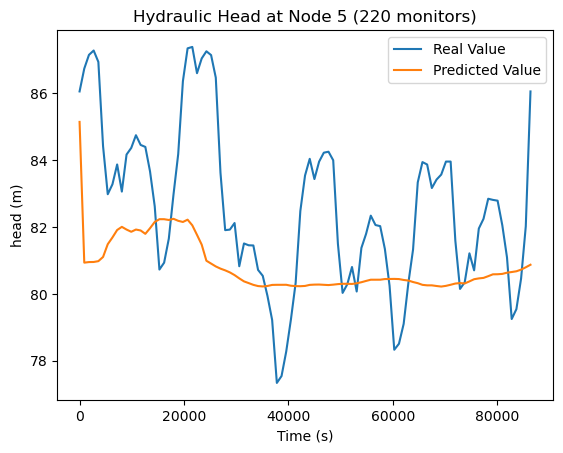

In [156]:
head_at_node5 = head.loc[:,'node_0005']
ax = head_at_node5.plot()
ax.set_xlabel("Time (s)")
ax.set_ylabel("head (m)")
Pre_ana = Pre_ana.set_index(head.index)

Pre_ana['Node 5'].plot(ax=ax)
plt.title('Hydraulic Head at Node 5 (220 monitors)')
plt.legend(['Real Value', 'Predicted Value'])
plt.savefig('Hydraulic Head at Node 5 (220 monitors).png')
plt.show()

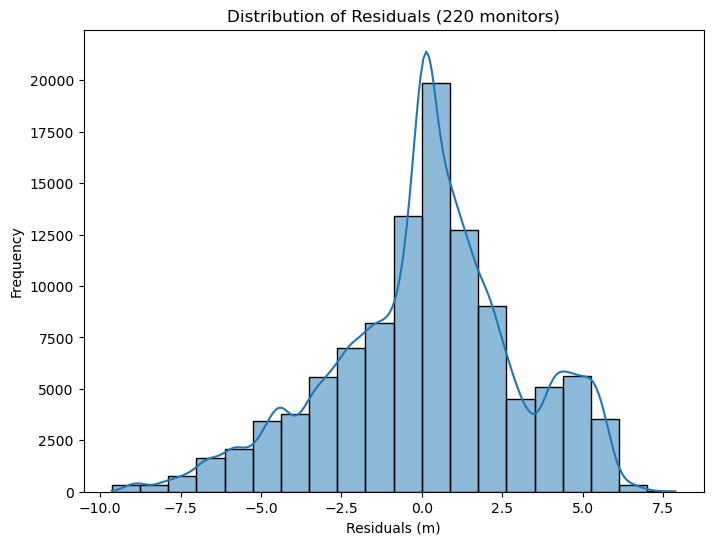

In [149]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.histplot(residuals, kde=True, bins=20)  # kde=True adds a Kernel Density Estimation curve
plt.xlabel('Residuals (m)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.title('Distribution of Residuals (220 monitors)')
plt.savefig('Distribution of Residuals (220 monitors).png')
plt.show()

In [145]:
RESI = ana[ana['node'].isin(monitor)]['residuals']
Other_RESI = ana[~ana['node'].isin(monitor)]['residuals']

In [133]:
new_value = pd.Series([3000])

# Concatenate the two Series
monitor = pd.concat([monitor, new_value], ignore_index=True)

In [131]:
RESI = np.array(RESI).reshape((-1, 221))
RESI = pd.DataFrame(RESI)
RESI.rename()

0         1         2         3         4         5         6    \
0   0.353348 -0.509056 -0.482094  0.167740  0.537354  0.402336  0.556969   
1   0.378418  0.225609  0.163773  0.760277  0.661385  0.415291  0.677307   
2   0.058357 -0.176651  0.222130  0.827110  0.192932  0.459709  0.748932   
3   0.443321  0.348984  0.242622  0.848999  0.756699  0.477890  0.771553   
4   0.348015  0.326973  0.174782  0.783859  0.699730  0.379799  0.713249   
..       ...       ...       ...       ...       ...       ...       ...   
92  0.241875 -0.597252 -0.391083  0.018509 -0.076904  0.567146 -0.060677   
93  0.182060 -0.587334 -0.388649  0.036407 -0.052361  0.516548 -0.036972   
94  0.070320 -0.546280 -0.364899  0.095306  0.018784  0.392036  0.031288   
95  0.011826 -0.459671 -0.312943  0.198418  0.134911  0.200798  0.145248   
96  0.353348  0.017792  0.093338  0.658936  0.537354  0.402336  0.556961   

         7         8         9    ...       211       212       213       214  \
0   0.558228  0.531448  1.513367  ...  0.248306  0.374779  0.053368 -0.225853   
1   0.678329 -0.030235  0.724785  ...  0.754623 -0.058914  0.725151  0.544662   
2   0.749901  0.551109  1.603157  ...  0.821777  0.611115  0.702759  0.624252   
3   0.772507  0.568420  1.622269  ...  0.843704  0.635139  0.710022  0.648125   
4   0.714119  0.462303  1.533554  ...  0.779037  0.589821  0.538116  0.601524   
..       ...       ...       ...  ...       ...       ...       ...       ...   
92 -0.059639  0.724236  1.214714  ...  0.013359 -0.293404  0.397530 -0.253288   
93 -0.035988  0.662163  1.209938  ...  0.031517 -0.218529  0.514580 -0.193161   
94  0.032082  0.532120  1.218498  ...  0.090965 -0.092415  0.730064 -0.079765   
95  0.145912  0.319458  1.244316  ...  0.194809  0.048340  0.862236  0.057808   
96  0.558228  0.531403  1.513268  ...  0.651993  0.374779  0.984016  0.392403   

         215       216       217       218       219       220  
0   0.337318 -0.223785 -0.195717  0.085373  1.013138  0.859657  
1   0.938683  0.524277  0.409225  0.752785  0.056351  0.437927  
2   0.903847  0.605026  0.453865  0.820030  0.726624  1.008682  
3   0.909035  0.629105  0.472115  0.841972  0.733650  1.029945  
4   0.696678  0.584282  0.374290  0.777466  0.553680  0.959274  
..       ...       ...       ...       ...       ...       ...  
92  0.422997 -0.311798  0.248077  0.011604  0.399803  0.211449  
93  0.541092 -0.229973  0.186111  0.029846  0.517151  0.226288  
94  0.761246 -0.097809  0.079849  0.089493  0.733459  0.278725  
95  0.891281  0.044281  0.021484  0.193588  0.865524  0.373169  
96  1.155350  0.367622  0.391281  0.649689  1.013130  0.859657  

[97 rows x 221 columns]

In [139]:
RESI = np.array(RESI).reshape((-1, 221))
RESI_df = pd.DataFrame(RESI[:221], columns=['Node ' + str(i) for i in monitor])
RESI_df.rename(columns={'Node 3000': 'Reservoir 1'}, inplace=True)

In [141]:
RESI_df

Node 841  Node 2629  Node 2109  Node 2382  Node 2532  Node 1835  \
0   0.353348  -0.509056  -0.482094   0.167740   0.537354   0.402336   
1   0.378418   0.225609   0.163773   0.760277   0.661385   0.415291   
2   0.058357  -0.176651   0.222130   0.827110   0.192932   0.459709   
3   0.443321   0.348984   0.242622   0.848999   0.756699   0.477890   
4   0.348015   0.326973   0.174782   0.783859   0.699730   0.379799   
..       ...        ...        ...        ...        ...        ...   
92  0.241875  -0.597252  -0.391083   0.018509  -0.076904   0.567146   
93  0.182060  -0.587334  -0.388649   0.036407  -0.052361   0.516548   
94  0.070320  -0.546280  -0.364899   0.095306   0.018784   0.392036   
95  0.011826  -0.459671  -0.312943   0.198418   0.134911   0.200798   
96  0.353348   0.017792   0.093338   0.658936   0.537354   0.402336   

    Node 2410  Node 2624  Node 1470  Node 814  ...   Node 23  Node 339  \
0    0.556969   0.558228   0.531448  1.513367  ...  0.248306  0.374779   
1    0.677307   0.678329  -0.030235  0.724785  ...  0.754623 -0.058914   
2    0.748932   0.749901   0.551109  1.603157  ...  0.821777  0.611115   
3    0.771553   0.772507   0.568420  1.622269  ...  0.843704  0.635139   
4    0.713249   0.714119   0.462303  1.533554  ...  0.779037  0.589821   
..        ...        ...        ...       ...  ...       ...       ...   
92  -0.060677  -0.059639   0.724236  1.214714  ...  0.013359 -0.293404   
93  -0.036972  -0.035988   0.662163  1.209938  ...  0.031517 -0.218529   
94   0.031288   0.032082   0.532120  1.218498  ...  0.090965 -0.092415   
95   0.145248   0.145912   0.319458  1.244316  ...  0.194809  0.048340   
96   0.556961   0.558228   0.531403  1.513268  ...  0.651993  0.374779   

    Node 502  Node 552  Node 525  Node 516  Node 1044  Node 1363  Node 523  \
0   0.053368 -0.225853  0.337318 -0.223785  -0.195717   0.085373  1.013138   
1   0.725151  0.544662  0.938683  0.524277   0.409225   0.752785  0.056351   
2   0.702759  0.624252  0.903847  0.605026   0.453865   0.820030  0.726624   
3   0.710022  0.648125  0.909035  0.629105   0.472115   0.841972  0.733650   
4   0.538116  0.601524  0.696678  0.584282   0.374290   0.777466  0.553680   
..       ...       ...       ...       ...        ...        ...       ...   
92  0.397530 -0.253288  0.422997 -0.311798   0.248077   0.011604  0.399803   
93  0.514580 -0.193161  0.541092 -0.229973   0.186111   0.029846  0.517151   
94  0.730064 -0.079765  0.761246 -0.097809   0.079849   0.089493  0.733459   
95  0.862236  0.057808  0.891281  0.044281   0.021484   0.193588  0.865524   
96  0.984016  0.392403  1.155350  0.367622   0.391281   0.649689  1.013130   

    Reservoir 1  
0      0.859657  
1      0.437927  
2      1.008682  
3      1.029945  
4      0.959274  
..          ...  
92     0.211449  
93     0.226288  
94     0.278725  
95     0.373169  
96     0.859657  

[97 rows x 221 columns]

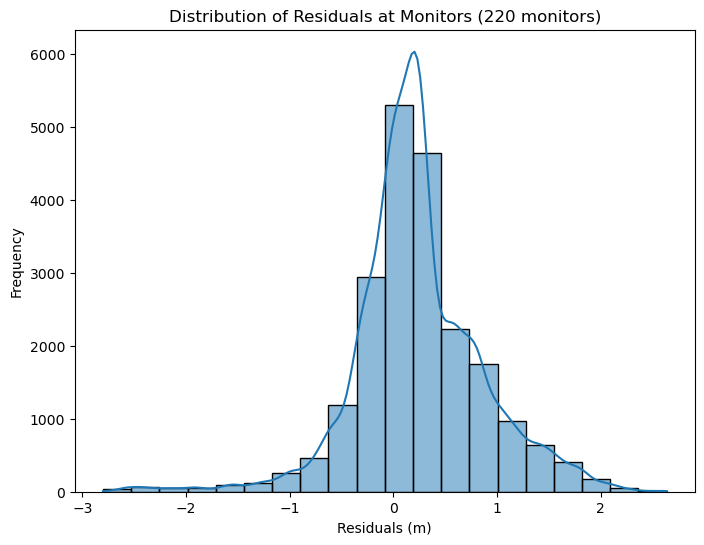

In [147]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.histplot(RESI, kde=True, bins=20)  # kde=True adds a Kernel Density Estimation curve
plt.xlabel('Residuals (m)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals at Monitors (220 monitors)')

plt.savefig('Distribution of Residuals at Monitors (220 monitors).png')
plt.show()

In [151]:
residuals.max()

7.891044616699219

In [152]:
residuals.min()

-9.639907836914062

In [153]:
RESI.max()

2.6350784301757812

In [154]:
RESI.min()

-2.80072021484375